# Construction de Psi

## Librairies

In [37]:
from kymatio.numpy import Scattering1D
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from maad.features import tfsd
from maad.sound import spectrogram
from maad.util import plot2d, power2dB
import os
import h5py

## Pour JobLib

In [38]:
from joblib import Memory
import time

cachedir = './joblib_cache'
memory = Memory(cachedir)

## Construction

### Outils

In [39]:
# Function to get the sound with filename
def getSound(filename, duration):
    fe, sound = wavfile.read(filename)
    nbSamples = round(fe * duration)
    sound = sound[0:nbSamples]
    return sound, fe

# Function to get the sound with position
def getSoundAtPosition(root, position, duration):
    return getSound(getFilenameAtPosition(root, position), duration)
    
# Function to get the filename with position
def getFilenameAtPosition(root, position):
    for root, dirnames, filenames in os.walk(root):
        f = filenames[position]
        filename = os.path.join(root, f)
        return filename

# Function to get the position with filename
def getPositionOfFilename(root, filename):
    for root, dirnames, filenames in os.walk(root):
        k = 0
        for f in filenames:
            if f == filename:
                return k
            else:
                k += 1
    
# Display the spectrogram of a sound
def displaySpectrogram(sound, fe, title, ax):
    
    spec, tn, fn, ext = spectrogram(sound, fe)   
    spec_dB = power2dB(spec)

    fig_kwargs = {'vmax': spec_dB.max(),'vmin':-70,'extent':ext,'title':title,'xlabel':'Time [sec]','ylabel':'Frequency [Hz]'}

    plot2d(spec_dB,**fig_kwargs, ax = ax, colorbar = False, now = False)

### Pertinence

In [40]:
def compute_pertinence(sound, fe):
    Spec, tn, fn, _ = spectrogram(sound, fe)
    q = tfsd(Spec, fn, tn)
    return np.sqrt(q)

### Descripteur

In [41]:
def compute_descriptor(sound, J, Q):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound / np.max(np.abs(sound)))

    order2 = np.where(scattering.meta()['order'] == 2)

    descriptor = scalogram[order2]
    descriptor = np.mean(descriptor, axis=1)
    descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor

### PSI

In [42]:
# Valeur maximale de nbSounds : 432
def compute_PSI(root, J, Q, duration, nbSounds):
    
    psi = [0] * nbSounds
    
    k = 0
    progress = -1
    for root, dirnames, filenames in os.walk(root):
        for f in filenames:
            
            if k >= nbSounds:
                break
                
            percentage = round(k/nbSounds * 100)
            if (percentage % 10) == 0 and percentage > progress:
                progress = percentage
                print(percentage, "%")
                
            filename = os.path.join(root, f)
            
            sound, fe = getSound(filename, duration)
            q = compute_pertinence(sound, fe)
            d = compute_descriptor(sound, J, Q)
            psi[k] = q*d
            k += 1
            
    print("DONE")
    
    return np.array(psi)



def getpsi():

    persisted_psi = h5py.File("./persisted_data/psi.hdf5", "a") # append mode : create file if it doesnt exist

    if 'psi_1' in persisted_psi:
        print("loading psi from persisted file")
        psi = persisted_psi['psi_1'][:]
    else:
        print("creating psi and persisting it to a file")
        J, Q = 8, 3
        psi = compute_PSI('./SoundDatabase', J, Q, 5, 432) 
        persisted_psi.create_dataset('psi_1', data=psi)

    persisted_psi.close()

    return psi

## Mesure de similarité

In [43]:
def distance_cosinus(position1, position2, psi):
    sound1 = psi[position1]
    sound2 = psi[position2]
    cos = np.dot(sound1, sound2) / (np.linalg.norm(sound1) * np.linalg.norm(sound2))
    return cos

In [44]:
def distance_cosinus_all(psi):
    nbSounds = psi.shape[0]
    distances = np.zeros((nbSounds, nbSounds))
    for j in range(nbSounds):
        for i in range(nbSounds):
            distances[i, j] = distance_cosinus(i, j, psi)
    return distances

loading psi from persisted file


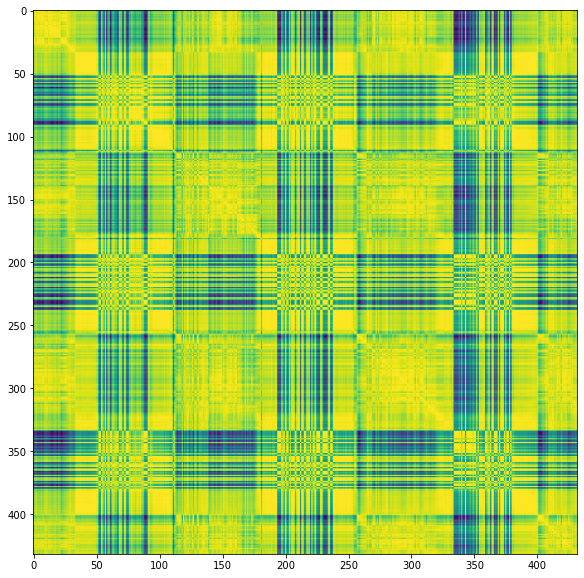

Distance cosinus moyennne :  0.8432643742044716
Distance cosinus minimale :  0.23455130133533825
Signaux les plus différents


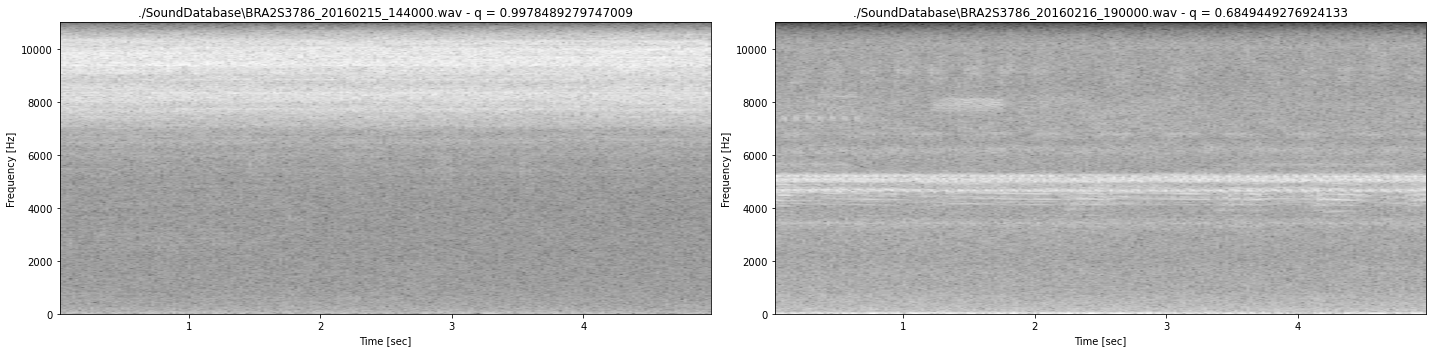

In [52]:
# Calcul de l'ensemble des distances
psi = getpsi()

distances = distance_cosinus_all(psi)

# Affichage de l'ensemble des distances
plt.figure(figsize=(10, 10))
plt.imshow(distances)
plt.show()

# Distance moyenne
print("Distance cosinus moyennne : ", np.mean(distances))

# Distance minimale
ind = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
print("Distance cosinus minimale : ", distances[ind])

# Spectrogramme des 2 signaux les plus différents
print("Signaux les plus différents")

root = './SoundDatabase'
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sound, fe = getSoundAtPosition(root, ind[0], 5)
title = "{} - q = {}".format(getFilenameAtPosition(root, ind[0]), compute_pertinence(sound, fe))
displaySpectrogram(sound, fe, title, ax[0])

sound, fe = getSoundAtPosition(root, ind[1], 5)
title = "{} - q = {}".format(getFilenameAtPosition(root, ind[1]), compute_pertinence(sound, fe))
displaySpectrogram(sound, fe, title, ax[1])

plt.show()


## Tri par pertinence

In [46]:
def compute_all_pertinence(root, duration = 5):
    
    q = {}

    for root, dirnames, filenames in os.walk(root):
            for f in filenames:
                filename = os.path.join(root, f)
                sound, fe = getSound(filename, duration)
                q[f] = compute_pertinence(sound, fe)
            
    q = dict(sorted(q.items(), key = lambda x: x[1]))

    return q

In [47]:
root = './SoundDatabase'

q = compute_all_pertinence(root)


MORE PERTINENT SOUNDS


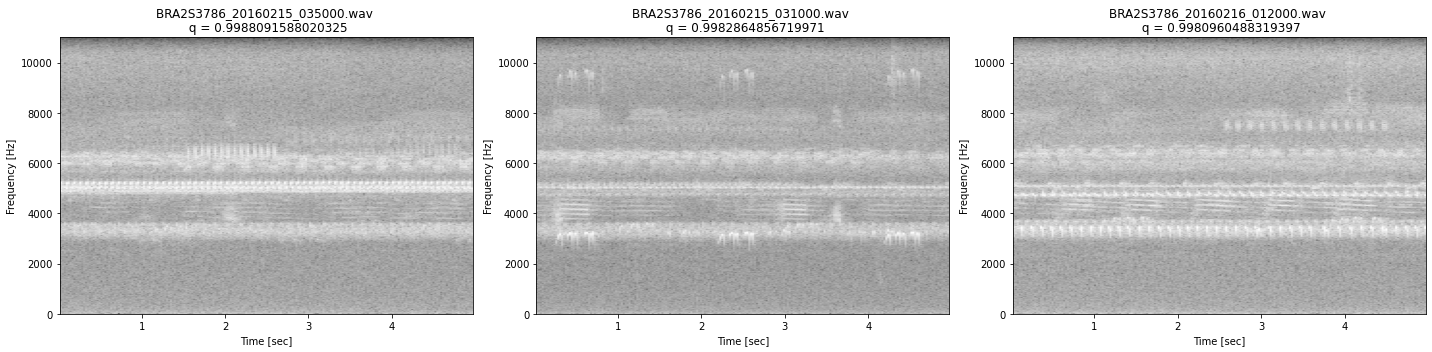

LEAST PERTINENT SOUNDS


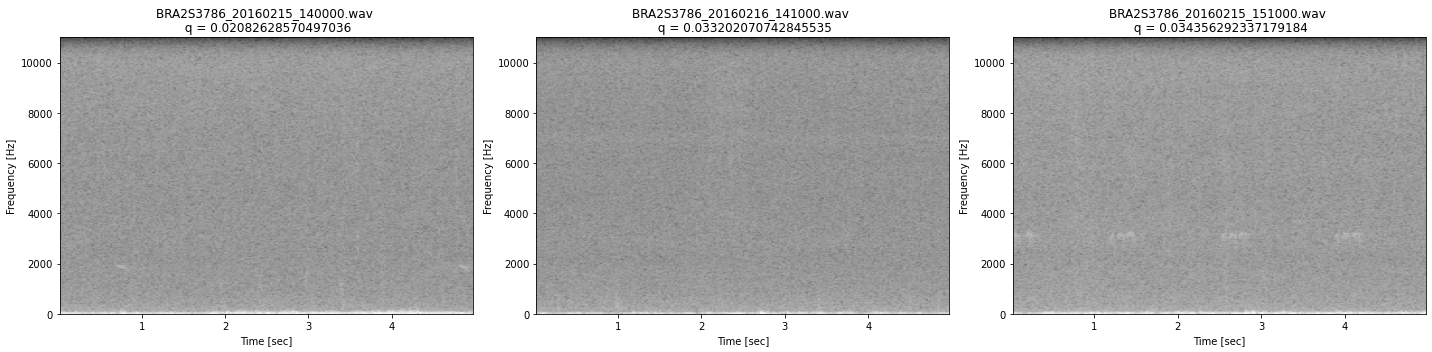

In [54]:
root = './SoundDatabase'
nbSounds = 432
pertinence_files = [list(q.items())[k][0] for k in range(nbSounds)]
pertinence_scores = [list(q.items())[k][1] for k in range(nbSounds)]

nbTop = 3

print("MORE PERTINENT SOUNDS")

fig, ax = plt.subplots(1, nbTop, figsize=(20, 5))
for k in range(nbTop):
    sound, fe = getSound(os.path.join(root, pertinence_files[nbSounds - k - 1]), 5)
    title = "{} \n q = {}".format(pertinence_files[nbSounds - k - 1], pertinence_scores[nbSounds - k - 1])
    
    displaySpectrogram(sound, fe, title, ax[k])

plt.show()


print("LEAST PERTINENT SOUNDS")

fig, ax = plt.subplots(1, nbTop, figsize=(20, 5))
for k in range(nbTop):
    sound, fe = getSound(os.path.join(root, pertinence_files[k]), 5)
    title = "{} \n q = {}".format(pertinence_files[k], pertinence_scores[k])
    
    displaySpectrogram(sound, fe, title, ax[k])

plt.show()

In [49]:
# Calcul des distances entre les signaux de pertinences maximales

root = './SoundDatabase'
nbSounds = 432
nbTop = 3

mean = 0
for i in range(nbTop):
    position1 = getPositionOfFilename(root, pertinence_files[nbSounds - i - 1])
    for j in range(i):
        position2 = getPositionOfFilename(root, pertinence_files[nbSounds - j - 1])
        mean += distance_cosinus(position1, position2, psi)
mean /= nbTop * (nbTop - 1) / 2

print(mean)

0.9104082462829127


## TEST

(69,)


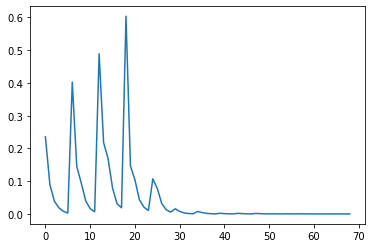

In [50]:
s, fe = getSound("./SoundDatabase/BRA2S3786_20160214_000000.wav", 1)
J, Q = 8, 3

d = compute_descriptor(s, J, Q)

print(d.shape)
plt.plot(d)
plt.show()

loading psi from persisted file
(432, 69)


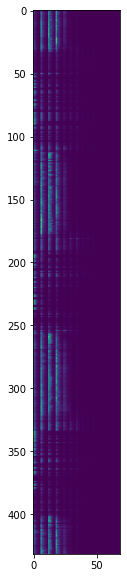

In [51]:
psi = getpsi()
print(psi.shape)
fig = plt.figure(figsize=(5, 10))
plt.imshow(psi)
plt.show()